In [ ]:
# %load  /home/mt/code/templates/firstcell.py
# %reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib agg

In [ ]:
# %load  /home/mt/code/templates/secondcell.py
import numpy as np
import os,pickle,sys,fnmatch,shutil
from os.path import join

import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
# %load  /home/mt/code/templates/mXANES.py
"""
Core functions used by t4iss
"""
__author__ = "Mehmet Topsakal"
__email__ = "metokal@gmail.com"
__status__ = "Development"
__date__ = "March 20, 2018"

from scipy.ndimage.filters import gaussian_filter1d
from scipy import interpolate
from scipy import signal
from scipy.stats import rankdata

class mXANES:
    
    def __init__(self, data=None, data_loadfrom=None, srange=None, structure=None, vcncutoff=5.0, ca=None, Eonset=None, 
                 xanesid=None, source=None, edge=None, multiplicity=1):
        
        super(mXANES, self).__init__()

        if data is None:
            if data_loadfrom:
                data = np.loadtxt(data_loadfrom, unpack=True, comments='#', skiprows=0)
                self.E0 = np.array(data[0])
                self.I0 = np.array(data[1])                
            else:
                self.E0 = np.array([])                
                self.I0 = np.array([])                               
        else:
            self.E0 = np.array(data[0])
            self.I0 = np.array(data[1])
            
        if srange:
            sel = (self.E0 >= srange[0]) & (self.E0 <= srange[1])
            self.E0 = self.E0[sel]
            self.I0 = self.I0[sel]            

        # Energy offset
        if Eonset is None:
            self.Eonset = self.E0[0]
        else:
            self.Eonset = Eonset
            
        # XANES id
        if xanesid is None:
            self.xanesid = 'not_set'
        else:
            self.xanesid = xanesid 
            
        # XANES edge
        if edge is None:
            self.edge = 'not_set'
        else:
            self.edge = edge         
            
        # source
        if source is None:
            self.source = 'not_set'
        else:
            self.source = source         
 
        # source
        if ca is None:
            self.ca = 'not_set'
        else:
            self.ca = ca     
            
        # structure
        if structure:
            try:               
                self.ca = structure[0][structure[1]].species_string            
                nnfinder = VoronoiNN(cutoff=vcncutoff,allow_pathological=True)
                vcn = nnfinder.get_cn(structure[0], structure[1], use_weights=True)
                self.vcn = vcn
                self.structure = [structure[0],structure[1],vcn]
            except Exception as exc:
                print(exc)
                self.structure = [structure[0],structure[1],[]]
                self.vcn = []
        else:
            self.structure = [[],[],[]] 
            self.vcn = []
        
        self.peaks = []
        self.multiplicity = multiplicity
        
        self.E = None
        self.I = None
                                         
    def Interpolate(self,iterprange,stepsize=0.1):               
        if self.E[0] > iterprange[0]:
            # left padding
            npts = int((self.E[0]-iterprange[0])/stepsize)+1
            x_patch = np.linspace(iterprange[0],self.E[0]-stepsize,npts)
            y_patch=np.empty(len(x_patch)); y_patch.fill(self.I[0])
            self.E = np.concatenate((x_patch,self.E.T), axis=0)
            self.I = np.concatenate((y_patch,self.I.T), axis=0)                       
        if self.E[-1] < iterprange[1]:
            # right padding            
            npts = int((iterprange[1]-self.E[-1])/stepsize)+2
            x_patch = np.linspace(self.E[-1],iterprange[1],npts)
            y_patch=np.empty(len(x_patch)); y_patch.fill(self.I[-1])
            self.E = np.concatenate((self.E.T,x_patch), axis=0)
            self.I = np.concatenate((self.I.T,y_patch), axis=0)             
        f = interpolate.interp1d(self.E,self.I,kind='linear')
        self.E = np.linspace(iterprange[0],iterprange[1], int((iterprange[1]-iterprange[0])/stepsize)+1  )      
        self.I = f(self.E) 
                
    def FindPeaks(self,xin=None,yin=None,srangep=None):        
        if (xin is None) or (yin is None):
            xsearch = self.E0
            ysearch = self.I0
        else:
            xsearch = xin
            ysearch = yin                       
        if srangep:
            sel = (xsearch >= srangep[0]) & (xsearch <= srangep[1])
            xsearch = xsearch[sel]; ysearch = ysearch[sel]        
        ipeaks = argrelextrema(ysearch, np.greater)[0]         
        peaks = []
        for i in ipeaks:
            peaks.append([xsearch[i],ysearch[i]])
        self.peaks = peaks        
        return peaks
  
    def yscale_by(self,yscale):
        self.I = self.I*yscale
        
    def normalize_to(self,nstr):
        if nstr == 'max':            
            self.I = self.I/max(self.I)
        elif nstr == 'tail':
            self.I = self.I/self.I[-1]      
        else:
            self.I = self.I 
            
    def broaden0(self, g_sigma=None,g_fwhm=None, l_gamma=None,l_fwhm=None, lvl=None):
        if g_sigma:
            self.E0, self.I0 = mconv(self.E0, self.I0).Gaussian(sigma=g_sigma)
        elif g_fwhm:
            self.E0, self.I0 = mconv(self.E0, self.I0).Gaussian(fwhm=g_fwhm) 
        if l_gamma:
            self.E0, self.I0 = mconv(self.E0, self.I0).Lorentzian(gamma=l_gamma)            
        elif l_fwhm:
            self.E0, self.I0 = mconv(self.E0, self.I0).Lorentzian(fwhm=l_fwhm)                   
        if lvl:            
            if len(lvl) == 1:
                self.E0, self.I0 = mconv(self.E0, self.I0).LorentzianVL(A=lvl[0],B=None,offset=None)
            elif len(lvl) == 2:
                self.E0, self.I0 = mconv(self.E0, self.I0).LorentzianVL(A=lvl[0],B=lvl[1],offset=None)               
            else:
                self.E0, self.I0 = mconv(self.E0, self.I0).LorentzianVL(A=lvl[0],B=lvl[1],offset=lvl[2])  

    def transform(self,srange=None,irange=None,x0shift=False,y0shift=False,
                  normalize='max',xshift=None,std=False):        
        self.E = self.E0.copy()
        self.I = self.I0.copy()        
        if x0shift:
            self.E = self.E -self.Eonset                        
        if xshift:
            self.E = self.E + xshift            
        if irange:
            self.Interpolate(irange)                  
        if y0shift:
            idx = (np.abs(sp.E - sp.Eonset)).argmin()
            self.I = self.I -self.I[idx]              
        if normalize == 'max':            
            self.I = self.I/max(self.I)
        elif normalize == 'tail':
            self.I = self.I/self.I[-1]
        elif normalize == 'none':
            self.I = self.I         
        else:
            self.I = self.I/max(self.I) 
        if std:
            self.I = (self.I-np.mean(self.I))/np.std(self.I)              
        self.rank = rankdata(self.I,method='average') / len(self.I)
        
        
    def get_nn(self, nnradius=10.01, axin=None, yshift=0, ms=9, lp='k-',ts=0, 
               text_off=False, x_label_on=False, y_label_on=False,
               atoms_off=False):
        
        from pymatgen.analysis.local_env import VoronoiNN
        from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
        import pymatgen as mg

        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
        from matplotlib.patches import Circle
        from matplotlib.offsetbox import AnchoredText        
               
        if self.structure:
            env = self.structure[0].get_sites_in_sphere(self.structure[0][self.structure[1]].coords,nnradius)
            def getKey(item): return item[1]
            self.env = sorted(env, key=getKey)            
            ss = []
            for i in env:
                ss.append(i[0].specie.name)
            self.species = list(set(ss)) 
            
            
            if not atoms_off:
                atext = []
                cs = []
                c = 0
                s = 10
                for i in self.species:  
                    ada = AnchoredDrawingArea(s*3, (len(self.species))*s, 0, 0, loc=2, pad=0., frameon=False)            
                    cs.append(Circle((s*2, c*s), 3, fc=get_c(i))); atext.append(i); c += 1
                
                at = AnchoredText('\n'.join(atext[::-1]),
                           loc=2, prop=dict(size=s), frameon=False, bbox_to_anchor=(0., 1.),
                           bbox_transform=axin.transAxes)  
                for i in cs:
                    ada.drawing_area.add_artist(i)
                ada.drawing_area.add_artist(at)               
                axin.add_artist(ada)

            if axin:
                                
                if self.vcn:
                    astr = 'mult.={:d}\nvcn={:04.2f}'.format(self.multiplicity,self.vcn)
                else:
                    astr = 'mult.={:d}\nvcn=na'.format(self.multiplicity)
                    
                if not text_off:
                    axin.annotate(astr,(-3,ts+yshift-0.1), fontsize=10, weight='bold')

                ss = []; ds = []
                for i in self.env:
                    ss.append(i[0].specie.name)
                    ds.append(i[1])
                ds = np.array(ds,np.float)
                
                axin.plot(yshift+ds[0:31],lp)
                

                for i,d in enumerate(ds[0:31]):
                    c = get_c(ss[i])
                    axin.plot( i, yshift+d, 'o', color=c, ms=ms, alpha=0.8 )

                axin.set_xticks(list(range(1,21)))
                if text_off:
                    axin.set_xlim([-0.5,31])
                else:
                    axin.set_xlim([-3.5,31])
                    
                if x_label_on:
                    axin.set_xlabel('Neighbour index #');
                if y_label_on:
                    axin.set_ylabel('Distance to absorbing atom ($\AA$)');                    

        else:
            env = []
            if axin:
                print('nn info is not available.')
        
        return env
    

class mconv:
    '''
    Does convolution with Gaussian or Lorentzian windows
    '''
     
    def __init__(self, datax, datay):
         
        self.datax = datax
        self.datay = datay
 
        self.NPoints = len(datax)
        self.X = np.array(datax)
      
    def w_gaussian(self, M, wsigma, dx):
        ''' see : https://github.com/scipy/scipy/blob/v0.19.0/scipy/signal/windows.py#L1159-L1219
        M should be odd number'''
        if wsigma <=0 : wsigma = 0.00001
        wsigma = wsigma/dx
        n = np.arange(0, M) - (M - 1.0) / 2.0
        wsigma2 = 2 * wsigma * wsigma
        wg = np.exp(-n ** 2 / wsigma2)    
        return wg
 
    def w_lorentzian(self, M, wgamma, dx):
        ''' '''
        wgamma = wgamma/dx
        if wgamma <=0 : wgamma = 0.00001
        n = np.arange(0, M) - (M - 1.0) / 2.0
        wl = 1 / ( ((2*n)/wgamma)**2 + 1  )    
        return wl             
             
    def Gaussian(self,sigma=None,fwhm=None,saveto=None):
         
        if fwhm:
            if sigma:
                print('ignoring input sigma')
        elif sigma:
            fwhm = sigma * np.sqrt(8 * np.log(2))
        else: 
            raise ValueError('sigma/fwhm was not set....')  
            
        self.sigma = fwhm/np.sqrt(8 * np.log(2))   
         
        M=101
        diff = [self.datax[i+1] - self.datax[i] for i in range(len(self.datax)-1)]; dx= np.sum(diff)/len(self.datax) 
        win = self.w_gaussian(M, self.sigma, dx)
        out = signal.convolve(self.datay, win, mode='same') / sum(win)
        
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"               
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )       
             
        return [self.X, out]
             
    def Lorentzian(self,gamma=None,fwhm=None,saveto=None,M=None):
        # in Lorentzian fwhm is equal to gamma
         
        if fwhm:
            if gamma:
                print('in Lorentzian fwhm is equal to gamma')
        elif gamma:
            fwhm = gamma
        else: 
            raise ValueError('sigma/fwhm was not set....')   
             
        self.gamma = fwhm 
         
        if M is None: M=1001
        diff = [self.datax[i+1] - self.datax[i] for i in range(len(self.datax)-1)]; dx= np.sum(diff)/len(self.datax) 
        win = self.w_lorentzian(M, self.gamma, dx)
        out = signal.convolve(self.datay, win, mode='same') / sum(win)
 
             
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"               
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )       
             
        return [self.X, out]    
      
    def LorentzianVL(self,saveto=None,fmt=None,M=None,A=None,B=None,offset=None):
        # gamma = A(x-offset) + B   
         
        if A is None: A=0.1
        if B is None: B=0          
        if offset is None: offset=self.datax[0]  
         
        gammas = []    
        for i,d in enumerate(self.datax):
            g = max(0,A*(d-offset)) + B
            gammas.append(g)
   
        if M is None: M=1001  
        diff = [self.datax[i+1] - self.datax[i] for i in range(len(self.datax)-1)]; dx= np.sum(diff)/len(self.datax) 
        out = np.zeros(self.NPoints)
         
                 
        for i, [gg, x0, y0] in enumerate(zip(gammas,self.datax,self.datay)):
            win = self.w_lorentzian(M, gg, dx)
            c = signal.convolve(self.datay, win, mode='same') / sum(win)
            out[i] = c[i]
                         
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"               
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )           
             
        #return [self.X, out], [self.datax, gammas]   
        return [self.X, out]
     
    def LorentzianVE2(self,saveto=None,fmt=None,M=None,offset=None):
        # gamma = (x-offset)^2 + B   
         
        if A is None: A=0.1
        if B is None: B=0          
        if offset is None: offset=self.datax[0]  
         
        gammas = []    
        for i,d in enumerate(self.datax):
            g = max(0,A*(d-offset)) + B
            gammas.append(g)
   
        if M is None: M=1001  
        diff = [self.datax[i+1] - self.datax[i] for i in range(len(self.datax)-1)]; dx= np.sum(diff)/len(self.datax) 
        out = np.zeros(self.NPoints)
                 
        for i, [gg, x0, y0] in enumerate(zip(gammas,self.datax,self.datay)):
            win = self.w_lorentzian(M, gg, dx)
            c = signal.convolve(self.datay, win, mode='same') / sum(win)
            out[i] = c[i]
                         
        if saveto:
            if fmt is None:
                fmt="%18.6e %18.6e"               
            of = np.column_stack( (self.X, out) )
            np.savetxt(str(saveto), of, delimiter=" ", fmt=fmt )           
             
        #return [self.X, out], [self.datax, gammas]   
        return [self.X, out]

    
    

# for element colors

Cdic =  {'H':[1.00000,0.80000,0.80000],
         'D':[0.80000,0.80000,1.00000],
         'He':[0.98907,0.91312,0.81091],
         'Li':[0.52731,0.87953,0.45670],
         'Be':[0.37147,0.84590,0.48292],
         'B':[0.12490,0.63612,0.05948],
         'C':[0.50430,0.28659,0.16236],
         'N':[0.69139,0.72934,0.90280],
         'O':[0.99997,0.01328,0.00000],
         'F':[0.69139,0.72934,0.90280],
         'Ne':[0.99954,0.21788,0.71035],
         'Na':[0.97955,0.86618,0.23787],
         'Mg':[0.98773,0.48452,0.08470],
         'Al':[0.50718,0.70056,0.84062],
         'Si':[0.10596,0.23226,0.98096],
         'P':[0.75557,0.61256,0.76425],
         'S':[1.00000,0.98071,0.00000],
         'Cl':[0.19583,0.98828,0.01167],
         'Ar':[0.81349,0.99731,0.77075],
         'K':[0.63255,0.13281,0.96858],
         'Ca':[0.35642,0.58863,0.74498],
         'Sc':[0.71209,0.38930,0.67279],
         'Ti':[0.47237,0.79393,1.00000],
         'V':[0.90000,0.10000,0.00000],
         'Cr':[0.00000,0.00000,0.62000],
         'Mn':[0.66148,0.03412,0.62036],
         'Fe':[0.71051,0.44662,0.00136],
         'Co':[0.00000,0.00000,0.68666],
         'Ni':[0.72032,0.73631,0.74339],
         'Cu':[0.13390,0.28022,0.86606],
         'Zn':[0.56123,0.56445,0.50799],
         'Ga':[0.62292,0.89293,0.45486],
         'Ge':[0.49557,0.43499,0.65193],
         'As':[0.45814,0.81694,0.34249],
         'Se':[0.60420,0.93874,0.06122],
         'Br':[0.49645,0.19333,0.01076],
         'Kr':[0.98102,0.75805,0.95413],
         'Rb':[1.00000,0.00000,0.60000],
         'Sr':[0.00000,1.00000,0.15259],
         'Y':[0.40259,0.59739,0.55813],
         'Zr':[0.00000,1.00000,0.00000],
         'Nb':[0.29992,0.70007,0.46459],
         'Mo':[0.70584,0.52602,0.68925],
         'Tc':[0.80574,0.68699,0.79478],
         'Ru':[0.81184,0.72113,0.68089],
         'Rh':[0.80748,0.82205,0.67068],
         'Pd':[0.75978,0.76818,0.72454],
         'Ag':[0.72032,0.73631,0.74339],
         'Cd':[0.95145,0.12102,0.86354],
         'In':[0.84378,0.50401,0.73483],
         'Sn':[0.60764,0.56052,0.72926],
         'Sb':[0.84627,0.51498,0.31315],
         'Te':[0.67958,0.63586,0.32038],
         'I':[0.55914,0.12200,0.54453],
         'Xe':[0.60662,0.63218,0.97305],
         'Cs':[0.05872,0.99922,0.72578],
         'Ba':[0.11835,0.93959,0.17565],
         'La':[0.35340,0.77057,0.28737],
         'Ce':[0.82055,0.99071,0.02374],
         'Pr':[0.99130,0.88559,0.02315],
         'Nd':[0.98701,0.55560,0.02744],
         'Pm':[0.00000,0.00000,0.96000],
         'Sm':[0.99042,0.02403,0.49195],
         'Eu':[0.98367,0.03078,0.83615],
         'Gd':[0.75325,0.01445,1.00000],
         'Tb':[0.44315,0.01663,0.99782],
         'Dy':[0.19390,0.02374,0.99071],
         'Ho':[0.02837,0.25876,0.98608],
         'Er':[0.28688,0.45071,0.23043],
         'Tm':[0.00000,0.00000,0.88000],
         'Yb':[0.15323,0.99165,0.95836],
         'Lu':[0.15097,0.99391,0.71032],
         'Hf':[0.70704,0.70552,0.35090],
         'Ta':[0.71952,0.60694,0.33841],
         'W':[0.55616,0.54257,0.50178],
         'Re':[0.70294,0.69401,0.55789],
         'Os':[0.78703,0.69512,0.47379],
         'Ir':[0.78975,0.81033,0.45049],
         'Pt':[0.79997,0.77511,0.75068],
         'Au':[0.99628,0.70149,0.22106],
         'Hg':[0.82940,0.72125,0.79823],
         'Tl':[0.58798,0.53854,0.42649],
         'Pb':[0.32386,0.32592,0.35729],
         'Bi':[0.82428,0.18732,0.97211],
         'Po':[0.00000,0.00000,1.00000],
         'At':[0.00000,0.00000,1.00000],
         'Rn':[1.00000,1.00000,0.00000],
         'Fr':[0.00000,0.00000,0.00000],
         'Ra':[0.42959,0.66659,0.34786],
         'Ac':[0.39344,0.62101,0.45034],
         'Th':[0.14893,0.99596,0.47106],
         'Pa':[0.16101,0.98387,0.20855],
         'U':[0.47774,0.63362,0.66714],
         'Np':[0.30000,0.30000,0.30000],
         'Pu':[0.30000,0.30000,0.30000],
         'Am':[0.30000,0.30000,0.30000],
         'XX':[0.30000,0.30000,0.30000]}



def get_c(element):
    return Cdic[element]
    

    
def read_feffnpz(npzfile):
    npzdata = np.load(npzfile)
    E = npzdata['_e_int']
    I = npzdata['_xmu_total']
    EIs = npzdata['_xmus_calculated_int']
    return [E,I,EIs]

In [ ]:
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import pymatgen as mg
from copy import deepcopy

In [ ]:
# alpha
struct = mg.Structure.from_file("K2MgCl4_springer.POSCAR.vasp")
finder = SpacegroupAnalyzer(struct,symprec=0.01)
struct = finder.get_symmetrized_structure()
[E,I,EIs] = read_feffnpz('feff.npz')
sp0 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,0,[]])
sp1 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,4,[]])
sp2 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,8,[]])
sp3 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,12,[]])

In [ ]:
struct

SymmetrizedStructure
Full Formula (K4 Mg2 Cl8)
Reduced Formula: K2MgCl4
abc   :   4.940000   4.940000  15.580000
angles:  90.000000  90.000000  90.000000
Sites (14)
  #  SP      a    b       c  Wyckoff
---  ----  ---  ---  ------  ---------
  0  Cl      0  0    0.1598  4e
  1  Cl      0  0.5  0       4c
  2  K       0  0    0.3567  4e
  3  Mg      0  0    0       2a

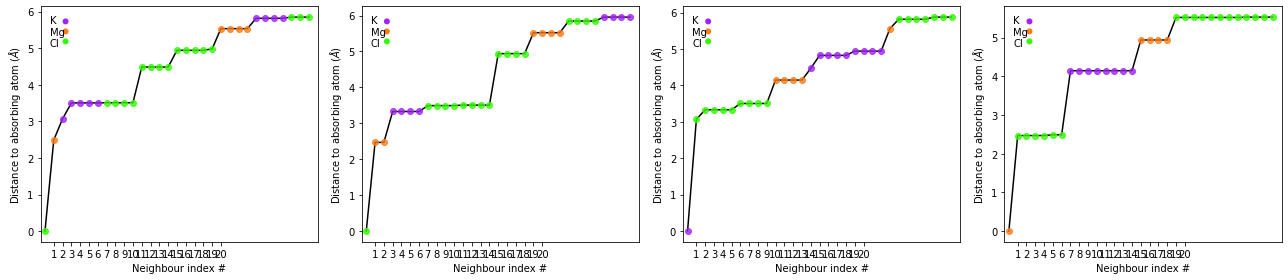

In [ ]:

fig = plt.figure(figsize=(18,4))

ax = fig.add_subplot(1,4,1)
sp0.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);
ax = fig.add_subplot(1,4,2)
sp1.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);
ax = fig.add_subplot(1,4,3)
sp2.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);
ax = fig.add_subplot(1,4,4)
sp3.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);

plt.tight_layout()

In [ ]:
# alpha
struct = mg.Structure.from_file("K4MgCl6_springer.POSCAR.vasp")
finder = SpacegroupAnalyzer(struct,symprec=0.01)
struct = finder.get_symmetrized_structure()
[E,I,EIs] = read_feffnpz('feff.npz')
sp0 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,0,[]])
sp1 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,4,[]])
sp2 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,8,[]])
sp3 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,12,[]])

In [ ]:
struct

SymmetrizedStructure
Full Formula (K24 Mg6 Cl36)
Reduced Formula: K4MgCl6
abc   :  11.980000  11.980000  14.486000
angles:  90.000000  90.000000 120.000000
Sites (66)
  #  SP          a        b        c  Wyckoff
---  ----  -------  -------  -------  ---------
  0  Cl    0.1911   0.03154  0.10229  36f
  1  K     0.37572  0        0.25     18e
  2  K     0        0        0.25     6a
  3  Mg    0        0        0        6b

In [ ]:
# alpha
struct = mg.Structure.from_file("K4MgCl6_springer.POSCAR.vasp")
finder = SpacegroupAnalyzer(struct,symprec=0.01)
struct = finder.get_symmetrized_structure()
[E,I,EIs] = read_feffnpz('feff.npz')
sp0 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,0,[]])
sp1 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,36,[]])
sp2 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,48,[]])
sp3 = mXANES(data=[E,I],xanesid='mp-0000',Eonset=8325,structure=[struct,60,[]])

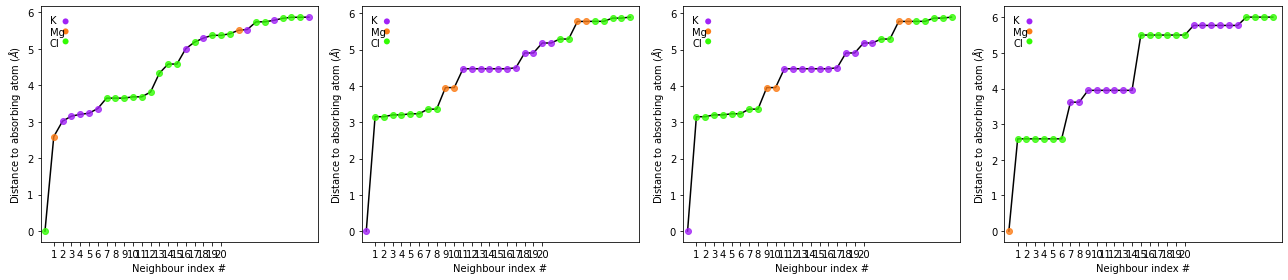

In [ ]:

fig = plt.figure(figsize=(18,4))

ax = fig.add_subplot(1,4,1)
sp0.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);
ax = fig.add_subplot(1,4,2)
sp1.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);
ax = fig.add_subplot(1,4,3)
sp2.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);
ax = fig.add_subplot(1,4,4)
sp3.get_nn(axin=ax,ts=1,ms=6,lp='k-',nnradius=10.01, yshift=0,text_off=True,y_label_on=True,x_label_on=True);

plt.tight_layout()